In [0]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from joblib import dump, load

In [0]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

##Deepfakes

In [0]:
deepfakes_data = pd.read_csv('/content/drive/My Drive/FakeImageDetector/dataset_drive/deepfakes_train_test_val.csv')
# faceswap_data = pd.read_csv('/content/drive/My Drive/FakeImageDetector/dataset_drive/faceswap_train_test_val.csv')
# neuraltextures_data = pd.read_csv('/content/drive/My Drive/FakeImageDetector/dataset_drive/neuraltextures_train_test_val.csv')
# face2face_data = pd.read_csv('/content/drive/My Drive/FakeImageDetector/dataset_drive/face2face_train_test_val2.csv')
real_data = pd.read_csv('/content/drive/My Drive/FakeImageDetector/dataset_drive/real_actors_train_test_val.csv')
real_data2 = pd.read_csv('/content/drive/My Drive/FakeImageDetector/dataset_drive/real_train_test_val.csv')
real_data3 = pd.read_csv('/content/drive/My Drive/FakeImageDetector/dataset_drive/real_youtube_train_test_val.csv')

real_data = real_data.append([real_data2])
del real_data2
real_data = real_data.append([real_data3])
del real_data3

In [0]:
# do train test split
data_train = deepfakes_data.loc[deepfakes_data.train_fixed == 'train']
data_test = deepfakes_data.loc[deepfakes_data.train_fixed == 'test']
data_val = deepfakes_data.loc[deepfakes_data.train_fixed == 'validation']
del deepfakes_data

data_train = data_train.append(real_data.loc[real_data.train == 'train'])
data_test= data_test.append(real_data.loc[real_data.train == 'test'])
data_val= data_val.append(real_data.loc[real_data.train == 'validation'])
del real_data

# train_labels = 'Deepfakes'
# test_labels = 'Deepfakes'
# val_labels = 'Deepfakes'
data_train = data_train.fillna('Reals')
data_test = data_test.fillna('Reals')
data_val = data_val.fillna('Reals')

In [0]:
train_labels = data_train.fake_real
test_labels = data_test.fake_real
val_labels = data_val.fake_real

In [0]:
train_Z = (data_train.drop(['Unnamed: 0', 'path_drive','train','fake_real','train_fixed'] , axis = 1))/255

In [0]:
pca = PCA(.9)

# Fit PCA on train_Z

train_Z_new = pca.fit_transform(train_Z)

In [0]:
from joblib import dump, load
dump(train_Z_new, '/content/drive/My Drive/FakeImageDetector/dataset_drive/train_pca.joblib') 

In [0]:
test_Z = (data_test.drop(['Unnamed: 0', 'path_drive','train','fake_real','train_fixed'] , axis = 1))/255
test_Z_new = pca.transform(test_Z)


In [0]:
dump(test_Z_new, '/content/drive/My Drive/FakeImageDetector/dataset_drive/test_pca.joblib') 

In [0]:
val_z =  (data_val.drop(['Unnamed: 0', 'path_drive','train','fake_real','train_fixed'] , axis = 1))/255
val_z_new = pca.transform(val_z)

In [0]:
dump(val_z_new, '/content/drive/My Drive/FakeImageDetector/dataset_drive/val_pca.joblib') 

In [0]:
loaded_train_pca = load('/content/drive/My Drive/FakeImageDetector/dataset_drive/train_pca.joblib')
# loaded_train_pca

In [0]:

del test_Z
del val_z
del train_Z

In [0]:
def shuffle_two_arrays(arr1, arr2):
    shuffler = np.random.permutation(arr1.size)
    array1_shuffled = arr1[shuffler]
    array2_shuffled = arr2[shuffler]

    return array1_shuffled, array2_shuffled

In [0]:
train_Z_new.shape
# (21965, 55)

In [0]:


np.isnan(test_Z_new[0]).any()
train_labels.shape

In [0]:
train_labels[-1]

In [0]:
train_labels = [0 if res == "Reals" else 1 for res in data_train.fake_real]

In [0]:
# condition_if_true if condition else condition_if_false
# train_labels = [1 if res == "Reals" else 0 for res in data_train.fake_real]
test_labels = [0 if res == "Reals" else 1 for res in data_test.fake_real]
val_labels = [0 if res == "Reals" else 1 for res in data_val.fake_real]

In [0]:
from sklearn.utils import shuffle
train_Z__sh, train_labels_sh = shuffle(train_Z_new, train_labels, random_state=0)
test_Z_sh, test_labels_sh = shuffle(test_Z_new, test_labels ,random_state=0)
val_z_sh, val_labels_sh = shuffle(val_z_new, val_labels, random_state=0)

In [0]:
train_Z__sh.shape
len(train_labels_sh)

In [0]:
#default
model = KNeighborsClassifier()
knn_res = model.fit(train_Z__sh, train_labels_sh)




In [0]:
dump(knn_res, '/content/drive/My Drive/FakeImageDetector/KNN/knn_res.joblib') 

In [0]:
print('trained on Deepfakes, tested on Deepfakes')
print('training acc: {:.2f}'.format(knn_res.score(train_Z__sh, train_labels_sh)))
print('test acc: {:.2f}'.format(knn_res.score(test_Z_sh, test_labels_sh)))
print('validation acc: {:.2f}'.format(knn_res.score(val_z_sh, val_labels_sh)))

In [0]:
y_test_pred =knn_res.predict(test_Z_sh)
y_val_pred = knn_res.predict(val_z_sh)

from sklearn.metrics import classification_report
print('trained on Deepfakes, tested on Deepfakes')
#target_names = ['class 0', 'class 1', 'class 2']
print(classification_report(test_labels_sh, y_test_pred))

In [0]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(test_labels_sh, y_test_pred, labels=[0,1]))
cm = confusion_matrix(test_labels_sh, y_test_pred, labels=[0,1])

In [0]:
print('trained on Deepfakes, tested on Deepfakes')
import seaborn as sns
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(knn_res.score)
plt.title("Confusion matrix");

##testing on other datasets

### FaceSwap


In [0]:
faceswap_data = pd.read_csv('/content/drive/My Drive/FakeImageDetector/dataset_drive/faceswap_train_test_val.csv')

In [0]:
faceswap_data.head(1)

In [0]:
new_labels = [0 for i in faceswap_data.fake_real]
len(new_labels)

In [0]:
fswp_features =(faceswap_data.drop(['Unnamed: 0', 'path_drive','train','fake_real','train_fixed'] , axis = 1))/255


In [0]:
del faceswap_data

In [0]:
pca2= PCA(n_components=55)
fswp_Z_test = pca2.fit_transform(fswp_features)

In [0]:
fswp_sh, fswp_labels_sh = shuffle(fswp_Z_test, new_labels ,random_state=0)

In [0]:
print('trained on Deepfakes, tested on FaceSwap')
# print('training acc: {:.2f}'.format(knn_res.score(train_Z__sh, train_labels_sh)))
print('test acc: {:.2f}'.format(knn_res.score(fswp_sh, fswp_labels_sh)))
# print('validation acc: {:.2f}'.format(knn_res.score(val_z_sh, val_labels_sh)))

In [0]:
y_test_pred_2 =knn_res.predict(fswp_sh)

from sklearn.metrics import classification_report
print('trained on Deepfakes, tested on FaceSwap')
#target_names = ['class 0', 'class 1', 'class 2']
print(classification_report(fswp_labels_sh, y_test_pred_2))

In [0]:
cm = confusion_matrix(fswp_labels_sh, y_test_pred_2, labels=[0,1])
print('trained on Deepfakes, tested on FaceSwap')
import seaborn as sns
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(knn_res.score)
plt.title("Confusion matrix");

###NeuralTextures

In [0]:
#load model

knn_model = load('/content/drive/My Drive/FakeImageDetector/KNN/knn_res.joblib')

In [0]:
#load data
neuraltextures_data = pd.read_csv('/content/drive/My Drive/FakeImageDetector/dataset_drive/neuraltextures_train_test_val.csv')

In [0]:
print('test acc: {:.2f}'.format(knn_model.score(test_Z_sh, test_labels_sh)))

##training on other datasets


###faceswp


In [0]:
# deepfakes_data = pd.read_csv('/content/drive/My Drive/FakeImageDetector/dataset_drive/deepfakes_train_test_val2.csv')
faceswap_data = pd.read_csv('/content/drive/My Drive/FakeImageDetector/dataset_drive/faceswap_train_test_val_2.csv')
# neuraltextures_data = pd.read_csv('/content/drive/My Drive/FakeImageDetector/dataset_drive/neuraltextures_train_test_val.csv')
# face2face_data = pd.read_csv('/content/drive/My Drive/FakeImageDetector/dataset_drive/face2face_train_test_val2.csv')

real_data = pd.read_csv('/content/drive/My Drive/FakeImageDetector/dataset_drive/real_train_test_val.csv')


NameError: ignored

In [0]:
faceswap_data['label'] = 1
real_data['label'] = 0
# do train test split
data_train = faceswap_data.loc[faceswap_data.train_fixed == 'train']
data_test = faceswap_data.loc[faceswap_data.train_fixed == 'test']
data_val = faceswap_data.loc[faceswap_data.train_fixed == 'validation']
del faceswap_data

data_train = data_train.append(real_data.loc[real_data.train == 'train'])
data_test= data_test.append(real_data.loc[real_data.train == 'test'])
data_val= data_val.append(real_data.loc[real_data.train == 'validation'])
del real_data


In [0]:
data_val.head(1)

In [0]:
train_labels = data_train.label
test_labels = data_test.label
val_labels = data_val.label

In [0]:
train_Z = (data_train.drop(['Unnamed: 0', 'path_drive','train','train_fixed', 'label'] , axis = 1))/255

In [97]:
pca = PCA(n_components = 550)

# Fit PCA on train_Z

train_Z_new = pca.fit_transform(train_Z)
dump(train_Z_new, '/content/drive/My Drive/FakeImageDetector/dataset_drive/fswap_train_pca.joblib') 

['/content/drive/My Drive/FakeImageDetector/dataset_drive/fswap_train_pca.joblib']

In [98]:
test_Z = (data_test.drop(['Unnamed: 0', 'path_drive','train','train_fixed',  'label'] , axis = 1))/255
test_Z_new = pca.transform(test_Z)
dump(test_Z_new, '/content/drive/My Drive/FakeImageDetector/dataset_drive/fswap_test_pca.joblib') 

['/content/drive/My Drive/FakeImageDetector/dataset_drive/fswap_test_pca.joblib']

In [99]:
val_z =  (data_val.drop(['Unnamed: 0', 'path_drive','train','train_fixed', 'label'] , axis = 1))/255
val_z_new = pca.transform(val_z)
dump(val_z_new, '/content/drive/My Drive/FakeImageDetector/dataset_drive/fswap_val_pca.joblib') 

['/content/drive/My Drive/FakeImageDetector/dataset_drive/fswap_val_pca.joblib']

In [0]:
del test_Z
del val_z
del train_Z

In [0]:
from sklearn.utils import shuffle
train_Z__sh, train_labels_sh = shuffle(train_Z_new, train_labels, random_state=0)
test_Z_sh, test_labels_sh = shuffle(test_Z_new, test_labels ,random_state=0)
val_z_sh, val_labels_sh = shuffle(val_z_new, val_labels, random_state=0)

In [0]:
model = KNeighborsClassifier()
knn_res = model.fit(train_Z__sh, train_labels_sh)

In [0]:
print('trained on FaceSwap, tested on FaceSwap')
print('training acc: {:.2f}'.format(knn_res.score(train_Z__sh, train_labels_sh)))
print('test acc: {:.2f}'.format(knn_res.score(test_Z_sh, test_labels_sh)))
print('validation acc: {:.2f}'.format(knn_res.score(val_z_sh, val_labels_sh)))

In [103]:
y_test_pred =knn_res.predict(test_Z_sh)

from sklearn.metrics import classification_report
print('trained on FaceSwap, tested on FaceSwap')
#target_names = ['class 0', 'class 1', 'class 2']
print(classification_report(test_labels_sh, y_test_pred))

trained on FaceSwap, tested on FaceSwap
              precision    recall  f1-score   support

           0       0.60      0.66      0.63      1468
           1       0.56      0.50      0.53      1269

    accuracy                           0.58      2737
   macro avg       0.58      0.58      0.58      2737
weighted avg       0.58      0.58      0.58      2737



In [104]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(test_labels_sh, y_test_pred, labels=[0,1]))
cm = confusion_matrix(test_labels_sh, y_test_pred, labels=[0,1])

[[964 504]
 [635 634]]


trained on FaceSwap, tested on FaceSwap


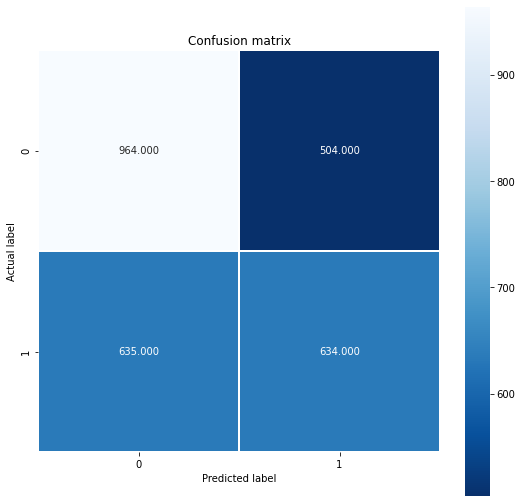

In [105]:
print('trained on FaceSwap, tested on FaceSwap')
import seaborn as sns
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(knn_res.score)
plt.title("Confusion matrix");

In [0]:
generated_model_path = '/content/drive/My Drive/FakeImageDetector/KNN/faceswap_knn2.pickle'
import pickle
pickle.dump(knn_res, open(generated_model_path, 'wb'))

###Deepfakes


In [0]:
deepfakes_data = pd.read_csv('/content/drive/My Drive/FakeImageDetector/dataset_drive/deepfakes_train_test_val_2.csv')
# faceswap_data = pd.read_csv('/content/drive/My Drive/FakeImageDetector/dataset_drive/faceswap_train_test_val_2.csv')
# neuraltextures_data = pd.read_csv('/content/drive/My Drive/FakeImageDetector/dataset_drive/neuraltextures_train_test_val.csv')
# face2face_data = pd.read_csv('/content/drive/My Drive/FakeImageDetector/dataset_drive/face2face_train_test_val2.csv')

real_data = pd.read_csv('/content/drive/My Drive/FakeImageDetector/dataset_drive/real_train_test_val.csv')


deepfakes_data['label'] = 1
real_data['label'] = 0

# do train test split
data_train = deepfakes_data.loc[deepfakes_data.train_fixed == 'train']
data_test = deepfakes_data.loc[deepfakes_data.train_fixed == 'test']
data_val = deepfakes_data.loc[deepfakes_data.train_fixed == 'validation']
del deepfakes_data

data_train = data_train.append(real_data.loc[real_data.train == 'train'])
data_test= data_test.append(real_data.loc[real_data.train == 'test'])
data_val= data_val.append(real_data.loc[real_data.train == 'validation'])
del real_data

train_labels = data_train.label
test_labels = data_test.label
val_labels = data_val.label

In [0]:
train_Z = (data_train.drop(['Unnamed: 0', 'path_drive','train','train_fixed', 'label'] , axis = 1))/255
pca = PCA(n_components = 550)

# Fit PCA on train_Z

train_Z_new = pca.fit_transform(train_Z)
dump(train_Z_new, '/content/drive/My Drive/FakeImageDetector/dataset_drive/deepfakes_train_pca.joblib') 
test_Z = (data_test.drop(['Unnamed: 0', 'path_drive','train','train_fixed',  'label'] , axis = 1))/255
test_Z_new = pca.transform(test_Z)
dump(test_Z_new, '/content/drive/My Drive/FakeImageDetector/dataset_drive/deepfakes_test_pca.joblib') 
val_z =  (data_val.drop(['Unnamed: 0', 'path_drive','train','train_fixed', 'label'] , axis = 1))/255
val_z_new = pca.transform(val_z)
dump(val_z_new, '/content/drive/My Drive/FakeImageDetector/dataset_drive/deepfakes_val_pca.joblib') 
del test_Z
del val_z
del train_Z

In [0]:
from sklearn.utils import shuffle
train_Z__sh, train_labels_sh = shuffle(train_Z_new, train_labels, random_state=0)
test_Z_sh, test_labels_sh = shuffle(test_Z_new, test_labels ,random_state=0)
val_z_sh, val_labels_sh = shuffle(val_z_new, val_labels, random_state=0)

trained on FaceSwap, tested on FaceSwap
              precision    recall  f1-score   support

           0       0.64      0.58      0.61      1468
           1       0.63      0.69      0.66      1537

    accuracy                           0.64      3005
   macro avg       0.64      0.64      0.63      3005
weighted avg       0.64      0.64      0.64      3005

[[ 853  615]
 [ 477 1060]]
trained on FaceSwap, tested on FaceSwap


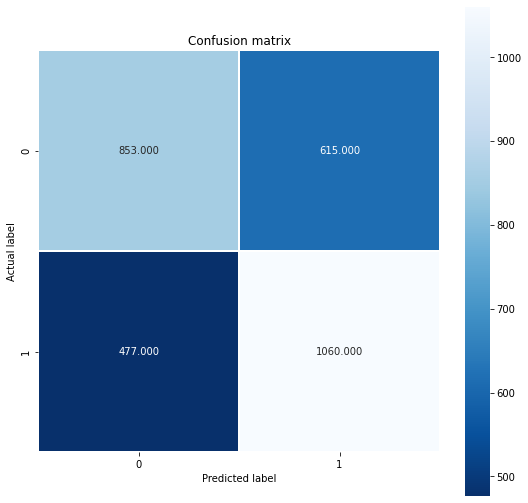

In [73]:
model = KNeighborsClassifier()
knn_res = model.fit(train_Z__sh, train_labels_sh)
y_test_pred =knn_res.predict(test_Z_sh)

from sklearn.metrics import classification_report
print('trained on FaceSwap, tested on FaceSwap')
#target_names = ['class 0', 'class 1', 'class 2']
print(classification_report(test_labels_sh, y_test_pred))
from sklearn.metrics import confusion_matrix
print(confusion_matrix(test_labels_sh, y_test_pred, labels=[0,1]))
cm = confusion_matrix(test_labels_sh, y_test_pred, labels=[0,1])
print('trained on FaceSwap, tested on FaceSwap')
import seaborn as sns
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(knn_res.score)
plt.title("Confusion matrix");

In [0]:
generated_model_path = '/content/drive/My Drive/FakeImageDetector/KNN/deepfakes_knn.pickle'
import pickle
pickle.dump(knn_res, open(generated_model_path, 'wb'))

###face2face



In [0]:
# deepfakes_data = pd.read_csv('/content/drive/My Drive/FakeImageDetector/dataset_drive/deepfakes_train_test_val_2.csv')
# faceswap_data = pd.read_csv('/content/drive/My Drive/FakeImageDetector/dataset_drive/faceswap_train_test_val_2.csv')
# neuraltextures_data = pd.read_csv('/content/drive/My Drive/FakeImageDetector/dataset_drive/neuraltextures_train_test_val.csv')
data = pd.read_csv('/content/drive/My Drive/FakeImageDetector/dataset_drive/face2face_train_test_val2.csv')

real_data = pd.read_csv('/content/drive/My Drive/FakeImageDetector/dataset_drive/real_train_test_val.csv')

data['label'] = 1
real_data['label'] = 0

# do train test split
data_train = data.loc[data.train_fixed == 'train']
data_test = data.loc[data.train_fixed == 'test']
data_val = data.loc[data.train_fixed == 'validation']
del data

data_train = data_train.append(real_data.loc[real_data.train == 'train'])
data_test= data_test.append(real_data.loc[real_data.train == 'test'])
data_val= data_val.append(real_data.loc[real_data.train == 'validation'])
del real_data

train_labels = data_train.label
test_labels = data_test.label
val_labels = data_val.label


In [76]:
data_train.columns

Index(['Unnamed: 0', '0', '1', '2', '3', '4', '5', '6', '7', '8',
       ...
       '19195', '19196', '19197', '19198', '19199', 'path', 'train',
       'train_fixed', 'label', 'path_drive'],
      dtype='object', length=19206)

In [0]:
train_Z = (data_train.drop(['Unnamed: 0', 'path', 'path_drive','train','train_fixed', 'label'] , axis = 1))/255
pca = PCA(n_components = 550)

# Fit PCA on train_Z

train_Z_new = pca.fit_transform(train_Z)
dump(train_Z_new, '/content/drive/My Drive/FakeImageDetector/dataset_drive/f2f_train_pca.joblib') 
test_Z = (data_test.drop(['Unnamed: 0','path', 'path_drive','train','train_fixed',  'label'] , axis = 1))/255
test_Z_new = pca.transform(test_Z)
dump(test_Z_new, '/content/drive/My Drive/FakeImageDetector/dataset_drive/f2f_test_pca.joblib') 
val_z =  (data_val.drop(['Unnamed: 0','path', 'path_drive','train','train_fixed', 'label'] , axis = 1))/255
val_z_new = pca.transform(val_z)
dump(val_z_new, '/content/drive/My Drive/FakeImageDetector/dataset_drive/f2f_val_pca.joblib') 
del test_Z
del val_z
del train_Z

In [0]:
from sklearn.utils import shuffle
train_Z__sh, train_labels_sh = shuffle(train_Z_new, train_labels, random_state=0)
test_Z_sh, test_labels_sh = shuffle(test_Z_new, test_labels ,random_state=0)
val_z_sh, val_labels_sh = shuffle(val_z_new, val_labels, random_state=0)

trained on FaceSwap, tested on FaceSwap
              precision    recall  f1-score   support

           0       0.53      0.40      0.46      1468
           1       0.60      0.72      0.65      1825

    accuracy                           0.58      3293
   macro avg       0.57      0.56      0.55      3293
weighted avg       0.57      0.58      0.57      3293

[[ 583  885]
 [ 510 1315]]
trained on FaceSwap, tested on FaceSwap


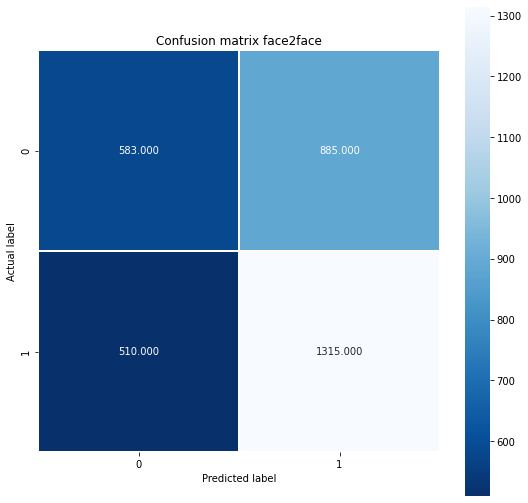

In [79]:
model = KNeighborsClassifier()
knn_res = model.fit(train_Z__sh, train_labels_sh)
y_test_pred =knn_res.predict(test_Z_sh)

from sklearn.metrics import classification_report
print('trained on FaceSwap, tested on FaceSwap')
#target_names = ['class 0', 'class 1', 'class 2']
print(classification_report(test_labels_sh, y_test_pred))
from sklearn.metrics import confusion_matrix
print(confusion_matrix(test_labels_sh, y_test_pred, labels=[0,1]))
cm = confusion_matrix(test_labels_sh, y_test_pred, labels=[0,1])
print('trained on FaceSwap, tested on FaceSwap')
import seaborn as sns
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(knn_res.score)
plt.title("Confusion matrix face2face");

In [0]:
generated_model_path = '/content/drive/My Drive/FakeImageDetector/KNN/face2face_knn.pickle'
import pickle
pickle.dump(knn_res, open(generated_model_path, 'wb'))

###NT

In [0]:
data = pd.read_csv('/content/drive/My Drive/FakeImageDetector/dataset_drive/neuraltextures_train_test_val_2.csv')
# data = pd.read_csv('/content/drive/My Drive/FakeImageDetector/dataset_drive/face2face_train_test_val2.csv')
real_data = pd.read_csv('/content/drive/My Drive/FakeImageDetector/dataset_drive/real_actors_train_test_val.csv')
real_data2 = pd.read_csv('/content/drive/My Drive/FakeImageDetector/dataset_drive/real_train_test_val.csv')
real_data3 = pd.read_csv('/content/drive/My Drive/FakeImageDetector/dataset_drive/real_youtube_train_test_val.csv')

real_data = real_data.append([real_data2])
del real_data2
real_data = real_data.append([real_data3])
del real_data3

data['label'] = 1
real_data['label'] = 0

# do train test split
data_train = data.loc[data.train_fixed == 'train']
data_test = data.loc[data.train_fixed == 'test']
data_val = data.loc[data.train_fixed == 'validation']
del data

data_train = data_train.append(real_data.loc[real_data.train == 'train'])
data_test= data_test.append(real_data.loc[real_data.train == 'test'])
data_val= data_val.append(real_data.loc[real_data.train == 'validation'])
del real_data

train_labels = data_train.label
test_labels = data_test.label
val_labels = data_val.label

In [0]:
data_train.columns

In [0]:
train_Z = (data_train.drop(['Unnamed: 0', 'path_drive','train','train_fixed', 'label'] , axis = 1))/255
pca = PCA(n_components = 550)

# Fit PCA on train_Z

train_Z_new = pca.fit_transform(train_Z)
dump(train_Z_new, '/content/drive/My Drive/FakeImageDetector/dataset_drive/NT_train_pca.joblib') 
test_Z = (data_test.drop(['Unnamed: 0', 'path_drive','train','train_fixed',  'label'] , axis = 1))/255
test_Z_new = pca.transform(test_Z)
dump(test_Z_new, '/content/drive/My Drive/FakeImageDetector/dataset_drive/NT_test_pca.joblib') 
val_z =  (data_val.drop(['Unnamed: 0', 'path_drive','train','train_fixed', 'label'] , axis = 1))/255
val_z_new = pca.transform(val_z)
dump(val_z_new, '/content/drive/My Drive/FakeImageDetector/dataset_drive/NT_val_pca.joblib') 
del test_Z
del val_z
del train_Z

In [0]:
from sklearn.utils import shuffle
train_Z__sh, train_labels_sh = shuffle(train_Z_new, train_labels, random_state=0)
test_Z_sh, test_labels_sh = shuffle(test_Z_new, test_labels ,random_state=0)
val_z_sh, val_labels_sh = shuffle(val_z_new, val_labels, random_state=0)

trained on NT, tested on NT
              precision    recall  f1-score   support

           0       0.70      0.71      0.70      2936
           1       0.30      0.29      0.30      1280

    accuracy                           0.58      4216
   macro avg       0.50      0.50      0.50      4216
weighted avg       0.58      0.58      0.58      4216

[[2086  850]
 [ 908  372]]
trained on NT, tested on NT


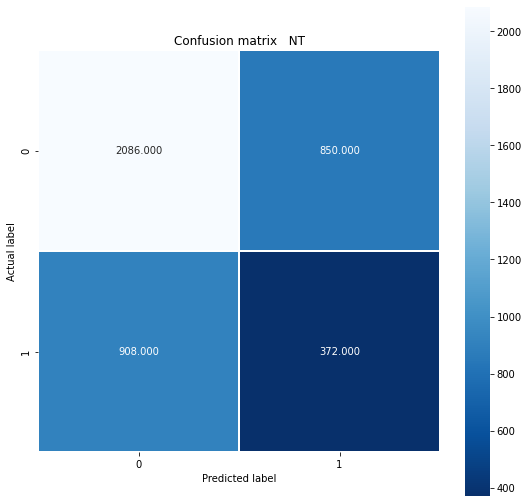

In [87]:
model = KNeighborsClassifier(n_neighbors=2)
knn_res = model.fit(train_Z__sh, train_labels_sh)
y_test_pred =knn_res.predict(test_Z_sh)

from sklearn.metrics import classification_report
print('trained on NT, tested on NT')
#target_names = ['class 0', 'class 1', 'class 2']
print(classification_report(test_labels_sh, y_test_pred))
from sklearn.metrics import confusion_matrix
print(confusion_matrix(test_labels_sh, y_test_pred, labels=[0,1]))
cm = confusion_matrix(test_labels_sh, y_test_pred, labels=[0,1])
print('trained on NT, tested on NT')
import seaborn as sns
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(knn_res.score)
plt.title("Confusion matrix   NT");

In [0]:
generated_model_path = '/content/drive/My Drive/FakeImageDetector/KNN/neuraltextures_knn.pickle'
import pickle
pickle.dump(knn_res, open(generated_model_path, 'wb'))